# IMDB Movie Dataset Analysis

## Introduction

This is the second part of the `imdb-crawler`, which analyses data crawled and stored in database in the first part. The data are from the top 250 movies of IMDB.
In this analysis, we try to answer the following question:

- Which factors make a movie a critically acclaimed movie?

According to IMDB, how a movie belongs in the top 250 is determined by:

>The list is ranked by a formula which includes the number of ratings each movie received from users, and value of ratings received from regular users.  
>To be included on the list, a movie must receive ratings from at least 25000 users

This means that a movie in the top 250 is usually critically acclaimed movies with huge followings. These movies may or may not perform well at the box office, as many movies with commercial success did not make the list.

The question above can be broken down to smaller problems for a better analysis:

- How do the attributes of a movie affect its greatness?
- Does revenue earned from the theatrical release phase affect the movie's overall popularity afterward?
- Does return on investment (ROI) an important factor that can affect the movie's overall popularity afterward?
- Does overall popularity and current popularity different? What factors contribute to each of them?
- What type of movie genres have the most impact on the movie greatness? What combination of movie genres are the best?

## Assumptions

To facilitate the analysis, the following assumption is created that establish a chronical relationships between entities related to a movie.

![Movie analysis](images/movie_analysis_factors.png)

The lifetime of a movie can be separated into 4 phases:

- __Production phase__: This is when the movie is created and its characteristics are defined. An idea/story is pitched, the cast and crew are formed during this phase, a budget is approved. With the story created, the movie would fall into one or several genres. After this phase, we have a set of innate characteristics of the movie. These characteristics might influence everything else in the following phases, such as critic reviews, commercial success, and popularity.
- __Limited viewings__: After production is finished, a movie is usually screened in limited viewing events, where critics are invited. The reviews of these critics can be an important factors that affect revenues and popularity afterward.
- __Theatrical releases__: The movie is released to theaters worldwide. In the data crawled from IMDB, revenues (either worldwide or domestic) are limited to theatrical releases only, which are how much the movie earned at the box office during its initial run, not including revenue from DVD rentals, television runs, etc. Also note that the figures are in nominal terms, and must be adjusted for inflation later.
- __Digital circulation__: Eventually, the movie is circulated online, through DVDs, renting, TV, etc. More people will have access to the movie and contribute to its overall popularity.

## Data processing

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans

sns.set_theme(style="dark")
%matplotlib inline

os.chdir("../")

from src.transform import db_output

In [2]:
from src.transform import db_input

We begin by importing packages that will be used during the analysis. 

It is __IMPORTANT__ to note that I have changed the working directory of this notebook to the parent directory, so that I can easily refer to files and modules in other directories. Because the path used is relative, everytime the above code cell is run again, the directory would be changed one more time and thus results in a wrong directory. 

Remember to __restart__ the notebook first if you need to rerun the above code cell.

---

Data is loaded from the database as below:

In [3]:
conn = sqlite3.connect("im.db")
cursor = conn.cursor()

### Feature list

New features are created using SQL. As the query is long, I saved it in a separated module at `src.transform.db_output`. New features are calculated for 3 groups of personnel, actors, directors and writers. Data used are rating, number of vote (rating_count) and revenue. Only data points occurs before the release of a movie are calculated.

With the features below, we can use a group of features as independent variables and access the its relationship with an other variable from the previous group.

*(\*) Exclude the top 250 movies, and only count movies before the target movies.*

| Phase | Feature                                     | Explanation                                                                                                                                                             |
|-------|---------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 2     | avg_movie_rating_by_star_actor *            | Average rating of all movies that the actors  (in leading roles of the target movie) have   participated in (also in leading roles).                                    |
| 1     | avg_movie_rating_count_by_star_actor *      | Average no. of votes of all movies that the actors  (in leading roles of the target movie) have   participated in (also in leading roles).                              |
| 1     | avg_movie_revenue_world_adj_by_star_actor * | Average worldwide revenue of all movies that the actors  (in leading roles of the target movie) have   participated in (also in leading roles). Adjusted for inflation. |
| 1     | avg_movie_rating_by_director *              | Average rating of all movies that the directors have directed.                                                                                                          |
| 1     | avg_movie_rating_count_by_director *        | Average no. of votes of all movies that the directors have directed.                                                                                                    |
| 1     | avg_movie_revenue_world_adj_by_director *   | Average worldwide revenue of all movies that the directors have directed.   Adjusted for inflation.                                                                     |
| 1     | avg_movie_rating_by_writer *                | Average rating of all movies that the writers have writing credits for.                                                                                                 |
| 1     | avg_movie_rating_count_by_writer *          | Average no. of votes of all movies that the writers have writing credits   for.                                                                                         |
| 1     | avg_movie_revenue_world_adj_by_writer *     | Average worldwide revenue of all movies that the writers have writing   credits for. Adjusted for inflation.                                                            |
| 1     | budget_adj                                  | Budget of target movie, adjusted for inflation to 2022 values.                                                                                                          |
| 2     | critic_review_count                         | Number of critic reviews of the target movie                                                                                                                            |
| 3     | revenue_world_adj                           | Worldwide revenue of target movie, adjusted for inflation to 2022 values.                                                                                               |
| 3     | revenue_usa_adj                             | USA (Domestic) revenue of target movie, adjusted for inflation to 2022   values.                                                                                        |
| 4     | popularity                                  | Current popularity of the target movie, as calculated by IMDB                                                                                                           |
| 4     | rating                                      | Weigted average rating of the target movie, as calculated by IMDB                                                                                                       |
| 4     | rating_count                                | Number of votes that made up the rating of the target movie                                                                                                             |

In [4]:
movies = pd.read_sql(db_output.movie_features_query, conn)
movies['release_date'] = pd.to_datetime(movies['release_date'], format="%Y-%m-%d")

In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 22 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   movie_rank                                 250 non-null    int64         
 1   movie_id                                   250 non-null    object        
 2   name                                       250 non-null    object        
 3   popularity                                 228 non-null    float64       
 4   rating                                     0 non-null      object        
 5   rating_count                               250 non-null    int64         
 6   critic_review_count                        250 non-null    int64         
 7   runtime                                    244 non-null    float64       
 8   release_date                               250 non-null    datetime64[ns]
 9   release_year         

## Analysis

We begin by creating 2 extra columns to calculate ROI, which will be used later to assess financial success of a movie.

In [6]:
movies['roi_world'] = (movies['revenue_world_adj'] - movies['budget_adj'])/movies['budget_adj']
movies['roi_usa'] = (movies['revenue_usa_adj'] - movies['budget_adj'])/movies['budget_adj']

movies['days_since_release'] = (pd.to_datetime(datetime.date.today()) - movies['release_date']).dt.days

It is also helpful to look at the correlation matrix to summarise the dataset and to see what kind of relationship the variables have with each other.

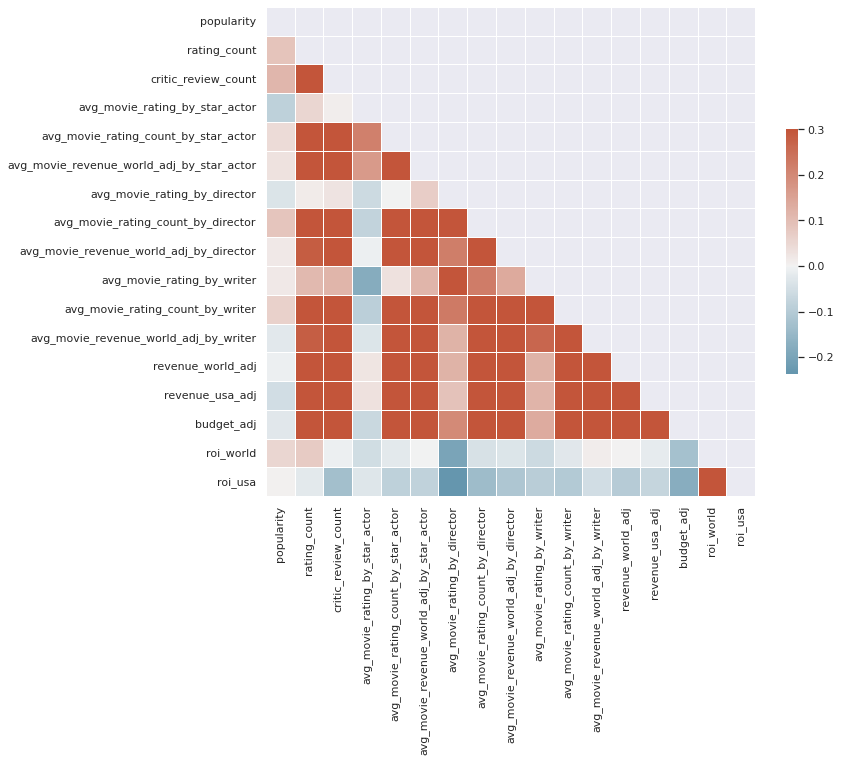

In [7]:
numerical_cols = [
    'rating', 'popularity', 'rating_count', 
    # 'days_since_release',
    'critic_review_count',
    'avg_movie_rating_by_star_actor',
    'avg_movie_rating_count_by_star_actor',
    'avg_movie_revenue_world_adj_by_star_actor',
    'avg_movie_rating_by_director',
    'avg_movie_rating_count_by_director',
    'avg_movie_revenue_world_adj_by_director',
    'avg_movie_rating_by_writer',
    'avg_movie_rating_count_by_writer',
    'avg_movie_revenue_world_adj_by_writer',
    'revenue_world_adj',
    'revenue_usa_adj',
    'budget_adj',
    'roi_world',
    'roi_usa'
    ]

def corr_matrix(df, num_cols):

    corr = df[num_cols].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

corr_matrix(movies, numerical_cols)

As seen above, among variables that can be used as independent variables, there are little to week correlations, which implies that multicollinearity (i.e. when two independent variables are highly correlated) is not a problem.

As such, we can proceed to use simple linear regrsesion using OLS method to analyze further.

In [8]:
def linear_regression(df, x_cols, y_col):
    new_data = df[x_cols + [y_col]].dropna()

    X = [list(row.values) for _, row in new_data[x_cols].iterrows()]
    X_OLS = sm.add_constant(X)
    y = new_data[y_col].values


    model = sm.OLS(y, X_OLS)
    model.data.xnames = ['const'] + x_cols
    results = model.fit()
    
    return results

### Commercial Success

#### Revenue worldwide

In this section, we look at revenue data, including world revenue, USA revenue and ROI.

According to the data, the highest grossing movies are:

In [9]:
movies.sort_values(by='revenue_world_adj', ascending=False).head(5)

,movie_rank,movie_id,name,popularity,rating,rating_count,critic_review_count,runtime,release_date,release_year,...,avg_movie_revenue_world_adj_by_director,avg_movie_rating_by_writer,avg_movie_rating_count_by_writer,avg_movie_revenue_world_adj_by_writer,revenue_world_adj,revenue_usa_adj,budget_adj,roi_world,roi_usa,days_since_release
80,80,tt4154796,Avengers: Hồi Kết,62.0,None,1049425,590,181.0,2019-04-26,2019,...,15.467963,6.728846,461768.0,16.291970,253.229378,77.699788,32.225064,6.858150,1.411160,1111
64,64,tt4154756,Avengers: Cuộc Chiến Vô Cực,127.0,None,1012215,628,149.0,2018-04-25,2018,...,15.467963,6.728846,461768.0,16.291970,182.117279,60.352693,28.539736,5.381183,1.114690,1477
102,102,tt10872600,Người Nhện: Không Còn Nhà,14.0,None,623725,382,148.0,2021-12-16,2021,...,12.874250,6.753488,462967.0,19.881503,181.580925,77.196379,19.188336,8.463089,3.023089,146
186,186,tt1201607,Harry Potter và Bảo Bối Tử Thần: Phần 2,426.0,None,845426,489,130.0,2012-02-03,2012,...,16.805367,7.429412,467970.0,15.433083,109.122829,31.008553,10.161472,9.738880,2.051581,3750
70,70,tt7286456,Joker,107.0,None,1190064,695,122.0,2019-10-04,2019,...,6.525398,6.130435,118805.0,3.940781,97.258658,30.367384,4.978591,18.535377,5.099594,950


In [10]:
x_cols = [
    # 'rating',
    # 'popularity', 
    # 'rating_count', 
    # 'revenue_world_adj',
    # 'revenue_usa_adj',
    # 'roi_usa',
    # 'roi_world',
    'critic_review_count',
    'avg_movie_rating_by_star_actor',
    'avg_movie_rating_count_by_star_actor',
    'avg_movie_revenue_world_adj_by_star_actor',
    'avg_movie_rating_by_director',
    'avg_movie_rating_count_by_director',
    'avg_movie_revenue_world_adj_by_director',
    'avg_movie_rating_by_writer',
    'avg_movie_rating_count_by_writer',
    'avg_movie_revenue_world_adj_by_writer',
    'budget_adj',
    ]

y_col = 'revenue_world_adj'

res = linear_regression(movies, x_cols, y_col)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     69.14
Date:                Wed, 11 May 2022   Prob (F-statistic):           7.85e-49
Time:                        18:41:22   Log-Likelihood:                -571.26
No. Observations:                 142   AIC:                             1167.
Df Residuals:                     130   BIC:                             1202.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                        -3.1864     34.147     -0.093      0.926     -70.741      64.369
critic_review_count                           0.0049      0.010      0.486      0.628      -0.015       0.025
avg_movie_rating_by_star_actor                8.2653      4.686      1.764      0.080      -1.006      17.537
avg_movie_rating_count_by_star_actor         -0.0002   5.91e-05     -2.846      0.005      -0.000   -5.13e-05
avg_movie_revenue_world_adj_by_star_actor     6.7987      2.156      3.153      0.002       2.533      11.065
avg_movie_rating_by_director                 -7.2535      2.914     -2.489      0.014     -13.019      -1.488
avg_movie_rating_count_by_director         4.471e-05   2.64e-05      1.694      0.093    -7.5e-06    9.69e-05
avg_movie_revenue_world_adj_by_director       0.0207      1.008      0.021      0.984      -1.974       2.016
avg_movie_rating_by_writer                   -0.3425      2.376     -0.144      0.886      -5.044       4.359
avg_movie_rating_count_by_writer          -5.822e-05   3.47e-05     -1.677      0.096      -0.000    1.05e-05
avg_movie_revenue_world_adj_by_writer         1.9569      1.144      1.710      0.090      -0.307       4.221
budget_adj                                    5.1908      0.413     12.566      0.000       4.374       6.008
==============================================================================
Omnibus:                       39.127   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.106
Skew:                           0.882   Prob(JB):                     5.17e-37
Kurtosis:                       8.013   Cond. No.                     6.59e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.59e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

__Significant variables:__

- By looking at the p-values and using a significance level of 5%, we can see that `avg_movie_revenue_world_adj_by_star_actor` and `budget_adj` are significant variables that have positive coefficients with `revenue_world_adj`. This means that:
    - An increase of `avg_movie_revenue_world_adj_by_star_actor` of $1M increases the adjusted worldwide revenue on average by $6.7M, holding all other predictors constant.
    - An increase of `budget_adj` of $1M increases the adjusted worldwide revenue on average by $5.19M, holding all other predictors constant.

This makes intuitive sense, because a large budget usually leads to more sales. Besides, the past average revenue of an actor is a good indicator for commercial success, as the normal movie watcher would be more attracted to the actors than to other aspects of a movie, such as the directors or writers.

The relationships can be visualized as below:

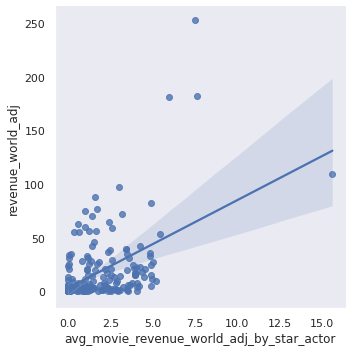

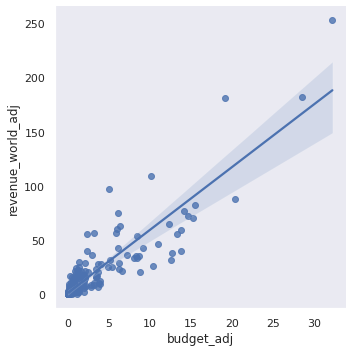

In [11]:
sns.lmplot(x='avg_movie_revenue_world_adj_by_star_actor', y=y_col, data=movies, 
scatter=True, fit_reg=True)

sns.lmplot(x='budget_adj', y=y_col, data=movies, 
scatter=True, fit_reg=True)

#### Return on Investment

Next, we look at ROI.

In [12]:
x_cols = [
    # 'rating',
    # 'popularity', 
    # 'rating_count', 
    # 'revenue_world_adj',
    # 'revenue_usa_adj',
    # 'roi_usa',
    # 'roi_world',
    'critic_review_count',
    'avg_movie_rating_by_star_actor',
    'avg_movie_rating_count_by_star_actor',
    'avg_movie_revenue_world_adj_by_star_actor',
    'avg_movie_rating_by_director',
    'avg_movie_rating_count_by_director',
    'avg_movie_revenue_world_adj_by_director',
    'avg_movie_rating_by_writer',
    'avg_movie_rating_count_by_writer',
    'avg_movie_revenue_world_adj_by_writer',
    'budget_adj',
    ]

y_col = 'roi_world'

res = linear_regression(movies, x_cols, y_col)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     2.217
Date:                Wed, 11 May 2022   Prob (F-statistic):             0.0171
Time:                        18:41:24   Log-Likelihood:                -579.48
No. Observations:                 142   AIC:                             1183.
Df Residuals:                     130   BIC:                             1218.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                       112.8843     36.182      3.120      0.002      41.303     184.466
critic_review_count                          -0.0014      0.011     -0.130      0.897      -0.023       0.020
avg_movie_rating_by_star_actor               -3.6930      4.966     -0.744      0.458     -13.517       6.131
avg_movie_rating_count_by_star_actor      -7.942e-05   6.26e-05     -1.268      0.207      -0.000    4.45e-05
avg_movie_revenue_world_adj_by_star_actor     3.4020      2.285      1.489      0.139      -1.118       7.922
avg_movie_rating_by_director                -10.3825      3.088     -3.362      0.001     -16.492      -4.273
avg_movie_rating_count_by_director         3.995e-05    2.8e-05      1.429      0.156   -1.54e-05    9.53e-05
avg_movie_revenue_world_adj_by_director      -1.6385      1.068     -1.533      0.128      -3.752       0.475
avg_movie_rating_by_writer                   -1.3348      2.518     -0.530      0.597      -6.316       3.647
avg_movie_rating_count_by_writer          -2.763e-05   3.68e-05     -0.751      0.454      -0.000    4.52e-05
avg_movie_revenue_world_adj_by_writer         1.6770      1.212      1.383      0.169      -0.722       4.076
budget_adj                                   -0.4627      0.438     -1.057      0.292      -1.329       0.403
==============================================================================
Omnibus:                      154.008   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3269.067
Skew:                           4.007   Prob(JB):                         0.00
Kurtosis:                      25.097   Cond. No.                     6.59e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.59e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Unlike the previous model for revenue, linear regression on ROI does not have a high $R^2=0.158$, which implies low correlation. We can also see in the correlation matrix above that ROI metrics have week correlations with independent variables.

### Popularity

Popularity can be determined with 2 metrics:

- `popularity` ranking on IMDB. This is the current popularity of the movie.
- `voting_count`, i.e. the number of votes that make up the rating. This can be understood as the popularity overtime of a title.

#### Popularity overtime

In [13]:
x_cols = [
    'avg_movie_rating_by_star_actor',
    'avg_movie_rating_count_by_star_actor',
    'avg_movie_revenue_world_adj_by_star_actor',
    'avg_movie_rating_by_director',
    'avg_movie_rating_count_by_director',
    'avg_movie_revenue_world_adj_by_director',
    'avg_movie_rating_by_writer',
    'avg_movie_rating_count_by_writer',
    'avg_movie_revenue_world_adj_by_writer',
    'budget_adj',
    'critic_review_count',
    'revenue_world_adj',
    'revenue_usa_adj',
    # 'rating',
    # 'popularity', 
    # 'rating_count', 
    # 'roi_usa',
    # 'roi_world',
    ]

y_col = 'rating_count'

res = linear_regression(movies, x_cols, y_col)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     7.890
Date:                Wed, 11 May 2022   Prob (F-statistic):           3.97e-11
Time:                        18:41:24   Log-Likelihood:                -1876.9
No. Observations:                 132   AIC:                             3782.
Df Residuals:                     118   BIC:                             3822.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                      2.142e+06   9.94e+05      2.155      0.033    1.74e+05    4.11e+06
avg_movie_rating_by_star_actor            -1.493e+05   1.34e+05     -1.111      0.269   -4.15e+05    1.17e+05
avg_movie_rating_count_by_star_actor          2.1951      1.671      1.313      0.192      -1.115       5.505
avg_movie_revenue_world_adj_by_star_actor -1.032e+04   6.13e+04     -0.168      0.867   -1.32e+05    1.11e+05
avg_movie_rating_by_director              -1.499e+05   8.23e+04     -1.821      0.071   -3.13e+05    1.31e+04
avg_movie_rating_count_by_director            2.4483      0.728      3.363      0.001       1.007       3.890
avg_movie_revenue_world_adj_by_director   -1.118e+05   2.74e+04     -4.076      0.000   -1.66e+05   -5.75e+04
avg_movie_rating_by_writer                 3.384e+04   6.75e+04      0.501      0.617   -9.98e+04    1.68e+05
avg_movie_rating_count_by_writer              0.5120      0.957      0.535      0.594      -1.384       2.408
avg_movie_revenue_world_adj_by_writer     -1.188e+04    3.2e+04     -0.371      0.711   -7.52e+04    5.15e+04
budget_adj                                 9975.5552   1.68e+04      0.592      0.555   -2.34e+04    4.33e+04
critic_review_count                          42.6438    282.811      0.151      0.880    -517.399     602.687
revenue_world_adj                         -9044.1455   4819.466     -1.877      0.063   -1.86e+04     499.709
revenue_usa_adj                            4.243e+04   1.34e+04      3.175      0.002     1.6e+04    6.89e+04
==============================================================================
Omnibus:                        5.868   Durbin-Watson:                   1.105
Prob(Omnibus):                  0.053   Jarque-Bera (JB):                5.408
Skew:                           0.423   Prob(JB):                       0.0669
Kurtosis:                       3.518   Cond. No.                     7.07e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.07e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

__Significant variables:__

- By looking at the p-values and using a significance level of 5%, we can see that `avg_movie_rating_count_by_star_actor`, `avg_movie_rating_count_by_director`, `avg_movie_rating_count_by_writer` and `budget_adj` are significant variables that have positive coefficients with `rating_count`.

Moreover, metrics calculated from `rating_count` of the cast and crew also tend to explain the final `rating_count` of the target movie. This is similar to revenue as seen above.

However, `rating_count` is different from `revenue`, as it implies the overall, or lifetime popularity of a movie. As such, all types of personnel, including directors, actors and writers affect the metric.

Finally, a large budget also leads to more more popularity. Higher budget means that the movie has more potential in terms of technicality and star power.

The relationships can be visualized as below:

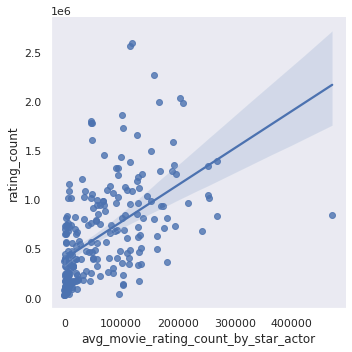

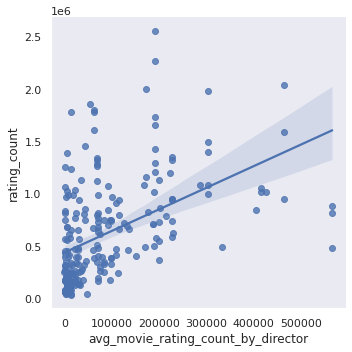

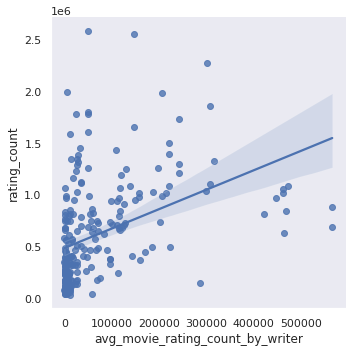

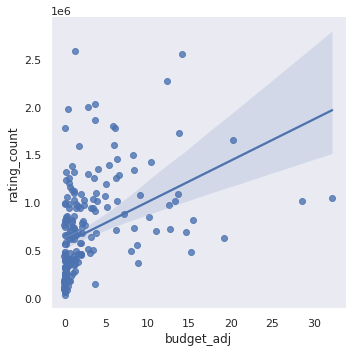

In [14]:
sns.lmplot(x='avg_movie_rating_count_by_star_actor', y=y_col, data=movies, 
scatter=True, fit_reg=True)

sns.lmplot(x='avg_movie_rating_count_by_director', y=y_col, data=movies, 
scatter=True, fit_reg=True)

sns.lmplot(x='avg_movie_rating_count_by_writer', y=y_col, data=movies, 
scatter=True, fit_reg=True)

sns.lmplot(x='budget_adj', y=y_col, data=movies, 
scatter=True, fit_reg=True)

#### Current Popularity

In [16]:
# x_cols = [
#     'avg_movie_rating_by_star_actor',
#     'avg_movie_rating_count_by_star_actor',
#     'avg_movie_revenue_world_adj_by_star_actor',
#     'avg_movie_rating_by_director',
#     'avg_movie_rating_count_by_director',
#     'avg_movie_revenue_world_adj_by_director',
#     'avg_movie_rating_by_writer',
#     'avg_movie_rating_count_by_writer',
#     'avg_movie_revenue_world_adj_by_writer',
#     'budget_adj',
#     'critic_review_count',
#     'revenue_world_adj',
#     'revenue_usa_adj',
#     'days_since_release',
#     'rating',
#     # 'popularity', 
#     'rating_count', 
#     # 'roi_usa',
#     # 'roi_world',
#     ]

# y_col = 'popularity'

# res = linear_regression(movies, x_cols, y_col)
# res.summary()

Current popularity, unlike lifetime popularity, does not yield good results when doing linear regression. 

This is probably because current popularity cannot be explained by the assumption of chronical relationships between entities above, as it is also affected by various external factors, such as trends, social and political climate, etc.

### Genres

A movie can be described with more than one genres. For example, a Sci-Fi movie also often falls into the Adventure category, or even Comedy. In this section, we attempts to answer 2 questions:

- What type of movie genres have the most impact on the movie greatness? 
- What combination of movie genres are the best?

These two questions can be very complicated to deep-dive into. Moreover, the data is limited (with 250 movies), and as such, we would only use very simple analysis and techniques to present some insights.

In [17]:
movie_genre = pd.read_sql(db_output.genre_query, conn)
movie_genre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   genre                    729 non-null    object 
 1   movie_rank               729 non-null    int64  
 2   movie_id                 729 non-null    object 
 3   name                     729 non-null    object 
 4   popularity               674 non-null    float64
 5   rating                   0 non-null      object 
 6   rating_count             729 non-null    int64  
 7   critic_review_count      729 non-null    int64  
 8   budget_adj               617 non-null    float64
 9   revenue_usa_adj          643 non-null    float64
 10  revenue_usa_opening_adj  594 non-null    float64
 11  revenue_world_adj        707 non-null    float64
 12  runtime                  710 non-null    float64
 13  opening_date             594 non-null    object 
 14  release_date             7

In [18]:
movie_genre['roi_world'] = (movie_genre['revenue_world_adj'] - movie_genre['budget_adj'])/movie_genre['budget_adj']
movie_genre['roi_usa'] = (movie_genre['revenue_usa_adj'] - movie_genre['budget_adj'])/movie_genre['budget_adj']

movie_genre['release_date'] = pd.to_datetime(movie_genre['release_date'], format="%Y-%m-%d")
movie_genre['days_since_release'] = (pd.to_datetime(datetime.date.today()) - movie_genre['release_date']).dt.days

First, we groups the data by movie genres and calculate various metrics, including mean, median, max, min. 

From the summary below, we can see that some movie genres stand out from the others, and that several genres can be grouped together into clusters in terms of revenue and the number of rating.

In [19]:
genre_summary = movie_genre.groupby('genre').agg({
    'rating':['count','mean', 'median', 'max', 'min' ,'std'],
    'rating_count':['count','mean', 'median', 'max', 'min' ,'std'],
    'critic_review_count':['count','mean', 'median', 'max', 'min' ,'std'],
    'revenue_usa_adj':['count','mean', 'median', 'max', 'min' ,'std'],
    'revenue_usa_opening_adj':['count','mean', 'median', 'max', 'min' ,'std'],
    'revenue_world_adj':['count','mean', 'median', 'max', 'min' ,'std'],
    'roi_world':['count','mean', 'median', 'max', 'min' ,'std'],
    'roi_usa':['count','mean', 'median', 'max', 'min' ,'std']
})

/home/truonghoang/miniconda3/envs/dtl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/truonghoang/miniconda3/envs/dtl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/truonghoang/miniconda3/envs/dtl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/truonghoang/miniconda3/envs/dtl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/truonghoang/miniconda3/envs/dtl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/truonghoang/miniconda3/envs/dtl/lib/pyt

In [20]:
genre_summary['rating']

,count,mean,median,max,min,std
genre,,,,,,
Action,0,NaN,NaN,NaN,NaN,NaN
Adventure,0,NaN,NaN,NaN,NaN,NaN
Animation,0,NaN,NaN,NaN,NaN,NaN
Biography,0,NaN,NaN,NaN,NaN,NaN
Comedy,0,NaN,NaN,NaN,NaN,NaN
Crime,0,NaN,NaN,NaN,NaN,NaN
Drama,0,NaN,NaN,NaN,NaN,NaN
Family,0,NaN,NaN,NaN,NaN,NaN
Fantasy,0,NaN,NaN,NaN,NaN,NaN


In [21]:
genre_summary['rating_count']

,count,mean,median,max,min,std
genre,,,,,,
Action,48,885506.541667,795064.0,2555086,37428,582498.795960
Adventure,60,752593.733333,714621.5,2268291,28231,495636.158415
Animation,23,612125.347826,687335.0,1083296,141788,298461.679909
Biography,29,518895.379310,393353.0,1340264,28231,369906.765753
Comedy,49,501562.612245,476504.0,1340264,35983,336336.659013
Crime,51,775229.980392,763425.0,2555086,33882,564194.815499
Drama,181,591299.232044,403916.0,2584686,28231,528167.394735
Family,27,548730.370370,476504.0,1083296,73479,321029.838296
Fantasy,32,752567.375000,671655.5,1797777,37428,446712.583338


In [22]:
genre_summary['critic_review_count']

,count,mean,median,max,min,std
genre,,,,,,
Action,48,290.437500,241.0,835,64,165.685026
Adventure,60,268.033333,220.5,835,54,164.514794
Animation,23,255.652174,227.0,593,116,125.052574
Biography,29,216.206897,156.0,512,54,141.904993
Comedy,49,231.489796,168.0,601,57,149.155976
Crime,51,242.862745,182.0,695,63,150.794565
Drama,181,231.453039,178.0,695,7,145.044760
Family,27,222.185185,194.0,593,7,138.382424
Fantasy,32,259.562500,212.0,593,115,123.628720


In [23]:
genre_summary['revenue_world_adj']

,count,mean,median,max,min,std
genre,,,,,,
Action,46,36.884170,22.968594,253.229378,1.627664e-04,51.418441
Adventure,58,36.707061,21.794816,253.229378,1.038006e-05,48.279810
Animation,22,35.541579,34.869840,82.377134,2.165357e-02,23.862929
Biography,28,10.625234,6.906823,33.975043,1.324555e-04,10.717244
Comedy,45,17.418438,5.094559,82.377134,1.671420e-04,22.547237
Crime,50,11.025812,2.581570,97.258658,7.923323e-07,21.090855
Drama,177,11.749915,2.029055,253.229378,7.923323e-07,25.570093
Family,26,28.828322,23.672455,82.377134,2.659345e-04,26.154791
Fantasy,32,35.327313,21.794816,181.580925,2.874660e-03,38.735130


In [24]:
genre_summary['roi_world']

,count,mean,median,max,min,std
genre,,,,,,
Action,37,8.001193,4.438391,69.490728,-0.637888,11.954854
Adventure,54,9.750094,5.700610,69.490728,-0.996380,13.345871
Animation,19,7.629055,4.334854,22.635818,-0.860281,6.505476
Biography,24,4.197722,2.604519,18.442479,-0.996380,4.680864
Comedy,37,6.449570,4.040937,27.363636,-0.970775,7.005039
Crime,41,5.960837,2.890261,40.723636,-0.999979,8.948122
Drama,146,7.383795,3.226735,121.135835,-0.999979,14.916078
Family,24,7.446246,4.261685,22.635818,-0.832160,6.483714
Fantasy,28,10.257483,7.747780,69.490728,0.926207,13.197326


#### Clustering

As such, we use K-Means algorithm to try to cluster the movie genres into groups. Due to time constraint and the scope of the problem, this section only stop at using the algorithm as a simple baseline, with the number of clusters being 4.

In [26]:
genre_summary_flat = genre_summary.copy(deep=True)
genre_summary_flat.columns = genre_summary_flat.columns.map('_'.join)
genre_summary_flat.reset_index(inplace=True)

In [27]:
X = genre_summary_flat[["revenue_world_adj_mean","rating_count_mean"]]

kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(X)

identified_clusters = kmeans.fit_predict(X)

# genre_clusters = genre_summary_flat.copy()
genre_summary_flat['clusters'] = identified_clusters 

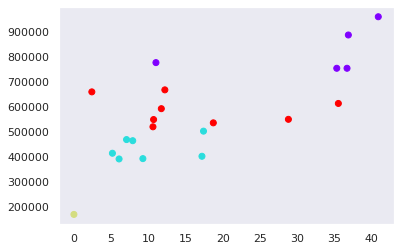

In [28]:
plt.scatter(genre_summary_flat['revenue_world_adj_mean'],genre_summary_flat['rating_count_mean'],c=genre_summary_flat['clusters'],cmap='rainbow')

In [29]:
genre_summary_flat[['genre','clusters']].sort_values(by='clusters')

,genre,clusters
0,Action,0
1,Adventure,0
16,Sci-Fi,0
5,Crime,0
8,Fantasy,0
17,Sport,1
15,Romance,1
13,Musical,1
19,War,1
10,History,1


We can see that there are 4 very clear groups of movie genres:
- The exiciting, high-performing genres: This group includes Action, Adventure, Sci-Fi, Crime, Fantasy.
- The plot-and-emotion-driven genres: Drama, Thriller, Mystery, Biography, etc. Perform worse in terms of commercial success, can have very high ratings.
- The slowburn genres: War, Musical, History, Comedy. These genres are a little slower and less plot driven than the previous group.
- The niche genres: Film-Noir, which is a niche genre that doesn't have a lot of fans.

In [30]:
movie_genre['cluster'] = movie_genre.merge(genre_summary_flat[['genre','clusters']], how='left', on='genre')['clusters']

In [31]:
movie_genre.groupby('cluster').agg({'rating_count':'mean', 'revenue_world_adj':'sum'})

,rating_count,revenue_world_adj
cluster,,
0,812633.605505,6611.934629
1,443352.109589,1430.946934
2,169048.500000,0.013345
3,590843.825485,5068.082029


In [32]:
movie_genre['cluster_label'] = movie_genre['cluster'].replace(
    {
        0: 4,
        3: 3,
        1: 2,
        2: 1
    }
)

#### Genre Pairing

After categorizing movie genres into groups, we can see what pairing of groups is the best. In this part, we pair the "best" genre (higher index) with the "worst" genre (lower index) for each movie.

In [33]:
movie_cluster = movie_genre.groupby('movie_id').agg({'cluster_label':['max','min']})
movie_cluster.columns = movie_cluster.columns.map('_'.join)
movie_cluster.reset_index(inplace=True)

In [34]:
movies[['cluster_max','cluster_min']] = movies.merge(movie_cluster, how='left', on='movie_id')[['cluster_label_max','cluster_label_min']]

In [35]:
movies.groupby(['cluster_max','cluster_min']).agg({
    'rating':['median','mean'],
    'rating_count':['median','mean'],
    'critic_review_count':['median','mean'],
    'revenue_world_adj':['median','mean'],
    'roi_world':['median','mean'],
})

/home/truonghoang/miniconda3/envs/dtl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/truonghoang/miniconda3/envs/dtl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/truonghoang/miniconda3/envs/dtl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/truonghoang/miniconda3/envs/dtl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/truonghoang/miniconda3/envs/dtl/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/truonghoang/miniconda3/envs/dtl/lib/pyt

rating      rating_count                \
                        median mean       median          mean   
cluster_max cluster_min                                          
2           2              NaN  NaN     287281.5  3.207075e+05   
3           1              NaN  NaN     169375.0  1.739903e+05   
            2              NaN  NaN     321794.0  4.518681e+05   
            3              NaN  NaN     401153.0  5.864615e+05   
4           1              NaN  NaN     154223.0  1.542230e+05   
            2              NaN  NaN     476504.0  5.366530e+05   
            3              NaN  NaN     730211.5  7.901354e+05   
            4              NaN  NaN    1012215.0  1.016802e+06   

                        critic_review_count             revenue_world_adj  \
                                     median        mean            median   
cluster_max cluster_min                                                     
2           2                         135.0  140.625000          0.104530   
3           1                         207.0  204.666667          0.002561   
            2                         154.5  202.071429          1.864602   
            3                         195.0  237.681818          1.825915   
4           1                         157.0  157.000000          0.000088   
            2                         174.0  245.346939         11.123991   
            3                         213.0  258.500000          4.159909   
            4                         244.0  275.846154         20.818216   

                                   roi_world             
                              mean    median       mean  
cluster_max cluster_min                                  
2           2             1.690669  4.238623   8.122179  
3           1             0.004419 -0.886306  -0.886306  
            2             6.736256  3.458030  10.201842  
            3             5.744949  3.870989  10.628665  
4           1             0.000088 -0.984697  -0.984697  
            2            19.469482  3.604178   6.420587  
            3            19.961109  3.780023   6.533993  
            4            43.279388  8.878579  15.122367

In [36]:
movies['cluster_pair'] = movies['cluster_max'].astype(str) + "_" + movies['cluster_min'].astype(str)

We can see that a combination of group 4 and 3 is the most frequent pairing in the top 250 movies, following by the 3-2, 4-2 and 3-3 pairing. These pairing also perform well in terms of rating count and revenue. 

- Pairing 4-3 also have the second highest number of average rating count.
- Pairing 4-2 have the second highest average revenue.

<AxesSubplot:xlabel='cluster_pair', ylabel='count'>

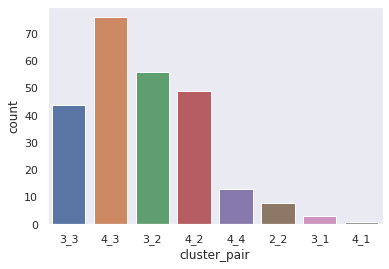

In [37]:
sns.countplot(x=movies['cluster_pair'])

From this, we can infer that a great movie deserving to be in the top 250 should have a balanced combination of excitement/action, as well as plot and emotions.

## Conclusion and Discussion

__From this analysis, we can have the following conclusions:__

- A movie should have a balanced combination of excitement/action, as well as plot and emotions to be considered a good/great movie.
- A movie tends to perform better when more star power (considering average past profit of these stars) and a good budget.
- A movie tends to have better lifetime popularity when combining star power and good directors/writers.

__However, the analysis also have several shortcomings and points of concern:__

- The number of data points is not a lot, not to mention many variable have null values, as the information is not always available, especially for older movies.
- Methodologies are not followed strictly, due to the limited scope of this analysis, which is to present insights.